<a href="https://colab.research.google.com/github/fidanaydamirova/education_gap/blob/main/education_gap_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Import pandas, numpy, and matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#seaborn is a data visualization library built on matplotlib
import seaborn as sns 
#set the plotting style 
sns.set_style("whitegrid")

#plot tree model
import graphviz

#Model preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

#Train-test splits and cross validation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV

from scipy.stats import uniform, randint

#Models
from sklearn.linear_model import LinearRegression, LogisticRegression, RidgeCV, LassoCV, Ridge, Lasso
import statsmodels.api as sm
from sklearn import neighbors, tree, svm
from sklearn.neural_network import MLPRegressor
import xgboost as xgb

#Model metrics
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix

#PCA
from sklearn.decomposition import PCA

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
edgap = pd.read_excel('https://raw.githubusercontent.com/brian-fischer/DATA-5100/main/EdGap_data.xlsx', dtype={'NCESSCH School ID':object})

In [ ]:
edgap.head()

,NCESSCH School ID,CT Unemployment Rate,CT Pct Adults with College Degree,CT Pct Childre In Married Couple Family,CT Median Household Income,School ACT average (or equivalent if SAT score),School Pct Free and Reduced Lunch
0,100001600143,0.117962,0.445283,0.346495,42820.0,20.433455,0.066901
1,100008000024,0.063984,0.662765,0.767619,89320.0,19.498168,0.112412
2,100008000225,0.056460,0.701864,0.713090,84140.0,19.554335,0.096816
3,100017000029,0.044739,0.692062,0.641283,56500.0,17.737485,0.296960
4,100018000040,0.077014,0.640060,0.834402,54015.0,18.245421,0.262641


In [ ]:
edgap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7986 entries, 0 to 7985
Data columns (total 7 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   NCESSCH School ID                                7986 non-null   object 
 1   CT Unemployment Rate                             7972 non-null   float64
 2   CT Pct Adults with College Degree                7973 non-null   float64
 3   CT Pct Childre In Married Couple Family          7961 non-null   float64
 4   CT Median Household Income                       7966 non-null   float64
 5   School ACT average (or equivalent if SAT score)  7986 non-null   float64
 6   School Pct Free and Reduced Lunch                7986 non-null   float64
dtypes: float64(6), object(1)
memory usage: 436.9+ KB


$\rightarrow$ Rename the columns.

In [ ]:
edgap = edgap.rename(columns={"NCESSCH School ID":"id", 
              "CT Pct Adults with College Degree":"percent_college",        
              "CT Unemployment Rate":"rate_unemployment", 
              "CT Pct Childre In Married Couple Family":"percent_married",
              "CT Median Household Income":"median_income",
              "School ACT average (or equivalent if SAT score)":"average_act",
              "School Pct Free and Reduced Lunch":"percent_lunch"})

##### $\rightarrow$ Set out-of-range values to `NaN`.


In [ ]:
edgap.loc[edgap['average_act'] < 1, 'average_act'] = np.nan

In [ ]:
edgap.loc[edgap['percent_lunch'] < 0, 'percent_lunch'] = np.nan

##### $\rightarrow$ What percentage of values of each variable are missing?



In [ ]:
edgap.isna().mean().round(4)*100

id                   0.00
rate_unemployment    0.18
percent_college      0.16
percent_married      0.31
median_income        0.25
average_act          0.04
percent_lunch        0.25
dtype: float64

##### $\rightarrow$ We aren't missing many values, so we will drop rows with missing observations.

In [ ]:
df = edgap.dropna()

### Exploratory data analysis

##### $\rightarrow$ Make a pair plot to explore relationships between the variables.

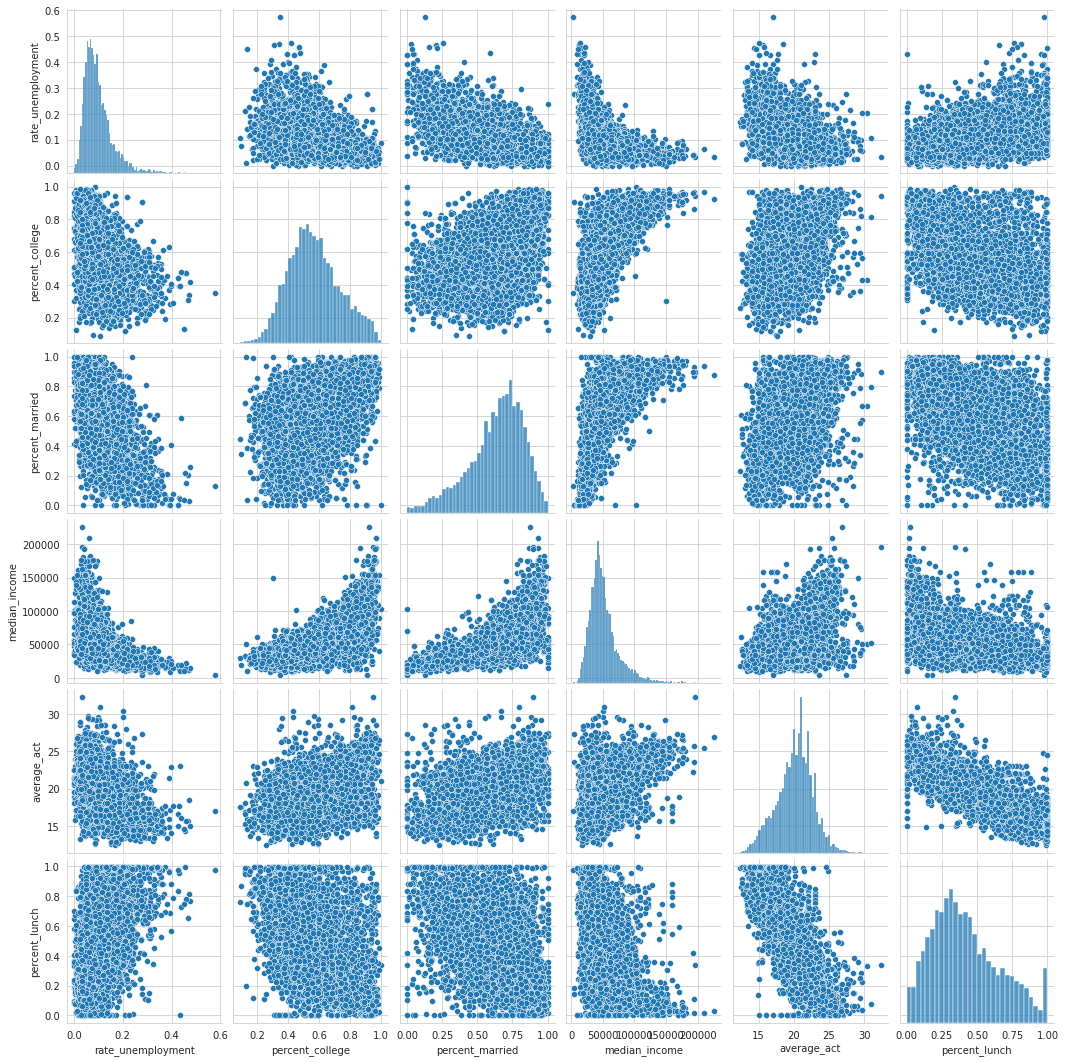

In [ ]:
sns.pairplot(df.drop(columns = 'id'))

From paiplot we can observe some positive relationship between rate of unemployment and percentage of free lunch. 
In addition there might be some negative relationship between average act score and percentage of free lunch at school.

##### $\rightarrow$ Plot the correlation matrix to explore relationships between the variables.

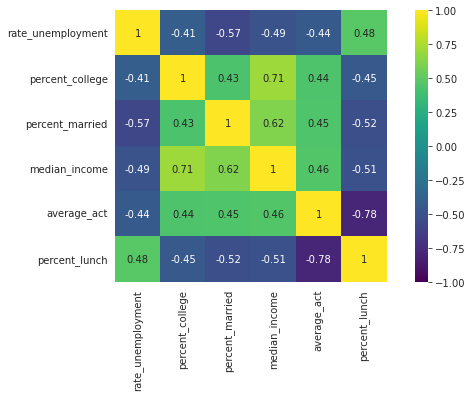

In [ ]:
corr_matrix = df.drop(columns='id').corr()
plt.figure(figsize=(10,5))
sns.heatmap(corr_matrix, vmax=1, vmin=-1, square=True, annot=True, cmap='viridis')



### Model

#### Get input and output variables.

##### $\rightarrow$ Which variable is the output variable and which variables are input variables?

In [ ]:
df.head(1)

,id,rate_unemployment,percent_college,percent_married,median_income,average_act,percent_lunch
0,100001600143,0.117962,0.445283,0.346495,42820.0,20.433455,0.066901


##### $\rightarrow$ Define the matrix of predictor variables `X` to be all columns except `id` and `average_act` and define the output variable `y` to be `average_act`.

In [ ]:
X = df[df.columns.difference(['id','average_act'])]
y = df['average_act']

In [ ]:
X.head()

,median_income,percent_college,percent_lunch,percent_married,rate_unemployment
0,42820.0,0.445283,0.066901,0.346495,0.117962
1,89320.0,0.662765,0.112412,0.767619,0.063984
2,84140.0,0.701864,0.096816,0.713090,0.056460
3,56500.0,0.692062,0.296960,0.641283,0.044739
4,54015.0,0.640060,0.262641,0.834402,0.077014


In [ ]:
y.head()

0    20.433455
1    19.498168
2    19.554335
3    17.737485
4    18.245421
Name: average_act, dtype: float64

#### Train and test splits

We will use the validation set approach to compare linear regression and KNN models predicting `average_act`. 

![](https://upload.wikimedia.org/wikipedia/commons/thumb/b/bb/ML_dataset_training_validation_test_sets.png/800px-ML_dataset_training_validation_test_sets.png)

##### $\rightarrow$ Split the data into training and testing sets. Keep 20% of the data for the test set.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [ ]:
print(X_train.shape, X_test.shape)

(6350, 5) (1588, 5)


##### $\rightarrow$ Check that the training and testing input variables have similar means and standard deviations.

In [ ]:
X_train.agg(['mean', 'std']).round(2)

,median_income,percent_college,percent_lunch,percent_married,rate_unemployment
mean,51980.27,0.57,0.42,0.63,0.10
std,24340.72,0.17,0.24,0.20,0.06


In [ ]:
X_test.agg(['mean', 'std']).round(2)

,median_income,percent_college,percent_lunch,percent_married,rate_unemployment
mean,52396.18,0.57,0.42,0.64,0.10
std,23772.99,0.16,0.24,0.19,0.06


The distributions should be similar overall. We are looking at the mean and standard deviation for simplicity.

#### Scaling

We are going to use KNN to predict `average_act` from the socioeconomic variables. The KNN method assumes that input variables have been similarly scaled.

While a scaling transformation is not required for multiple linear regression models, scaling does help us to interpret the relative importance of each predictor based on the magnitude of the estimated coefficients.

##### $\rightarrow$ Scale the predictor variables in the training set to have mean 0 and standard deviation 1.

Define the scaler using only the training data. For the validation set approach to work, we can not incorporate any knowledge of the validation set's properties into the model building process.

In [ ]:
scaler = preprocessing.StandardScaler().fit(X_train)

##### $\rightarrow$ Perform the scaling transform on the predictors in the training and testing sets.

In [ ]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

##### $\rightarrow$ Check the mean and standard deviation of the transformed data.

In [ ]:
print(np.mean(X_train, axis = 0))
print(np.std(X_train, axis = 0))

print(np.mean(X_test, axis = 0))
print(np.std(X_test, axis = 0))

[ 5.37103170e-17 -5.11366977e-16  1.68963706e-16 -2.55124006e-16
 -1.56655091e-16]
[1. 1. 1. 1. 1.]
[ 0.0170884   0.02507226 -0.02619697  0.01882766 -0.01996427]
[0.97644517 0.98098094 1.00706423 0.96569747 0.99517727]


#### Fit models to training data

##### $\rightarrow$ Specify the models we want to fit. We will fit linear regression and KNN models.

In [ ]:
models = [LinearRegression(),
          neighbors.KNeighborsRegressor(n_neighbors = 5)]

#Creating a list of names is not requied, but will be used in labeling plots
names = ['Lin. Reg.', 'KNN']

##### $\rightarrow$ Fit the models, compute the mean squared error value of the predictions, and plot the predictions vs. measured test values.

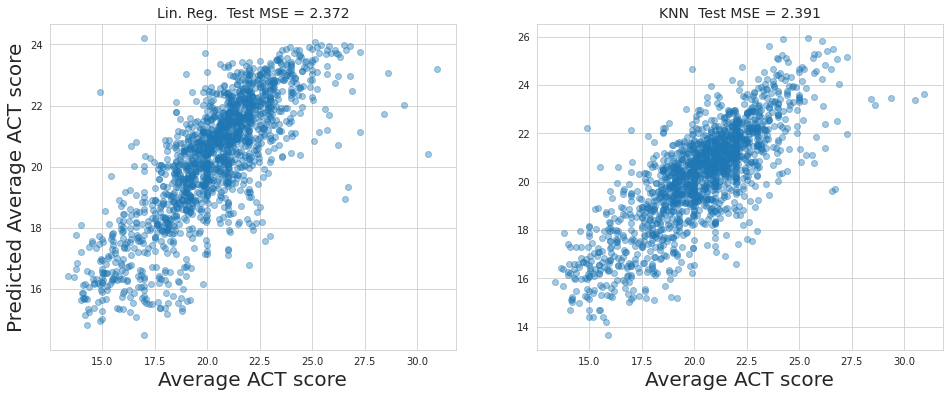

In [ ]:
figure = plt.figure(figsize=(16, 6))

scores = np.zeros(len(names))

i = 1
for name, model in zip(names, models):
  #Fit the model      
  model.fit(X_train, y_train)

  #Compute test mean squared error
  scores[i-1] = mean_squared_error(y_test, model.predict(X_test))

  #Compute test r-squared 
  #scores[i-1] = r2_score(y_test, model.predict(X_test))
  #scores[i-1] = model.score(X_test, y_test)
  
  #Plot predictions
  plt.subplot(1,2,i)
  plt.plot(y_test,model.predict(X_test),'o', alpha = 0.4)
  plt.xlabel('Average ACT score',fontsize = 20)
  plt.title(name + ' ' + ' Test MSE = ' + str(scores[i-1].round(3)),fontsize = 14)
  #plt.title(name + ' ' + ' Test R^2 = ' + str(scores[i-1].round(3)),fontsize = 14)
  if (i == 1) | (i == 5):
    plt.ylabel('Predicted Average ACT score',fontsize = 20);

  #Update index
  i += 1

plt.subplots_adjust(hspace = 0.5)

#### Cross-validation to find k in k-nearest neighbors

##### $\rightarrow$ Create a KNN model.

In [ ]:
knn = neighbors.KNeighborsRegressor()

##### $\rightarrow$ Define the parameters of the cross-validation search.

In [ ]:
#Values of k to test
ks = np.arange(2, 60, 2)
#Define the set of parameters to tune(just k)
tuned_parameters = [{"n_neighbors": ks}]
#Specify the number of folds
n_folds = 5

##### $\rightarrow$ Use cross-validation to find the best k

Do the cross-validation search using `GridSearchCV`

In [ ]:
modelCV = GridSearchCV(knn, tuned_parameters, cv=n_folds, refit=False, scoring='neg_mean_squared_error').fit(X_train, y_train)

Extract the CV scores and find the best k

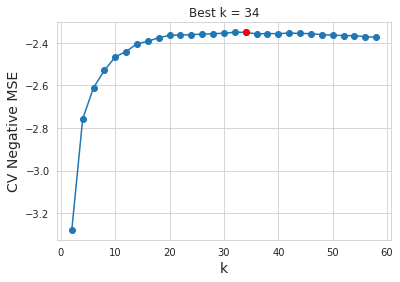

In [ ]:
#Get the r-squared scores
scores = modelCV.cv_results_["mean_test_score"]

#Get the best value of k
best_k = modelCV.best_params_['n_neighbors']

#Plot
plt.plot(ks, scores,'o-')
plt.plot(best_k, scores[ks == best_k],'ro')

plt.xlabel('k', fontsize = 14)
plt.ylabel('CV Negative MSE', fontsize = 14)
#plt.ylabel('CV R-squared', fontsize = 14)
plt.title('Best k = ' + str(best_k));

##### $\rightarrow$ Compare the performance of the linear regression model and the KNN model with the best k.

In [ ]:
models = [LinearRegression(),
          neighbors.KNeighborsRegressor(n_neighbors = best_k)]

names = ['Lin. Reg.', 'KNN']

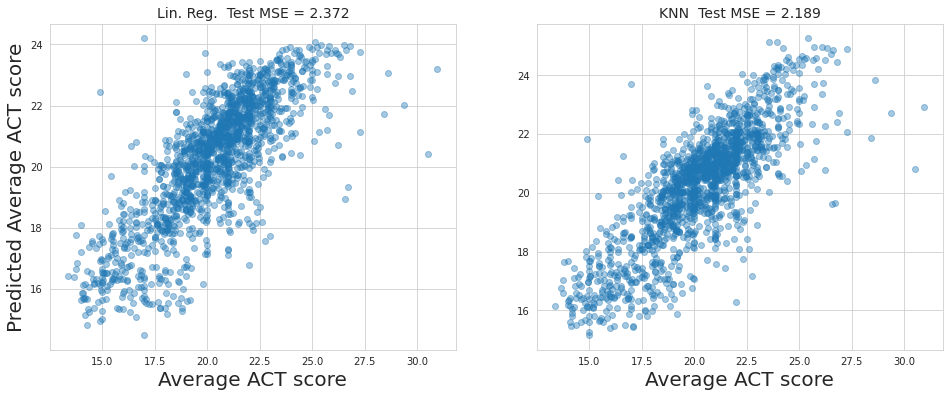

In [ ]:
figure = plt.figure(figsize=(16, 6))

scores = np.zeros(len(names))

i = 1
for name, model in zip(names, models):
  #Fit the model      
  model.fit(X_train, y_train)

  #Compute test mean squared error
  scores[i-1] = mean_squared_error(y_test, model.predict(X_test))

  #Compute r-squared 
  #scores[i-1] = r2_score(y_test, model.predict(X_test))
  #scores[i-1] = model.score(X_test, y_test)

  #Plot predictions
  plt.subplot(1,2,i)
  plt.plot(y_test, model.predict(X_test), 'o', alpha = 0.4)
  plt.xlabel('Average ACT score',fontsize = 20)
  plt.title(name + ' ' + ' Test MSE = ' + str(scores[i-1].round(3)),fontsize = 14)
  #plt.title(name + ' ' + ' Test R^2 = ' + str(scores[i-1].round(3)),fontsize = 14)
  if (i == 1) | (i == 5):
    plt.ylabel('Predicted Average ACT score',fontsize = 20);
  #plt.xlim(12.5, 30); plt.ylim(14, 26)

  #Update index
  i += 1

plt.subplots_adjust(hspace = 0.5)

#### Multiple linear regression

##### $\rightarrow$ Fit the multiple linear regression model and view the coefficients. Do the signs of the coefficients make sense? 

In [ ]:
lin_reg = models[0].fit(X_train, y_train)

Display the coefficients

In [ ]:
coefficients = lin_reg.coef_.round(2)
coefficients = np.insert(coefficients, 0, lin_reg.intercept_.round(2))

variables = X.columns
variables = np.insert(variables, 0, 'intercept')

pd.DataFrame(data = coefficients, index = variables, columns = ['Estimated Coefficient'])

,Estimated Coefficient
intercept,20.17
median_income,-0.01
percent_college,0.28
percent_lunch,-1.82
percent_married,0.02
rate_unemployment,-0.13


We can see the relative importance of the predictors, but we don't know which we should keep in the model. We need further investigation (p-values, subset selection, etc).

##### $\rightarrow$ Use statsmodels to examine the statistical significance of the coefficients.

Fit the model.

In [ ]:
model = sm.OLS(y_train, sm.add_constant(X_train)).fit() 

Print the summary

In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            average_act   R-squared:                       0.627
Model:                            OLS   Adj. R-squared:                  0.627
Method:                 Least Squares   F-statistic:                     2135.
Date:                Wed, 15 Dec 2021   Prob (F-statistic):               0.00
Time:                        00:53:40   Log-Likelihood:                -11852.
No. Observations:                6350   AIC:                         2.372e+04
Df Residuals:                    6344   BIC:                         2.376e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.1720      0.020   1027.059      0.000      20.134      20.211
x1            -0.0115      0.033     -0.354      0.723      -0.075       0.052
x2             0.2757      0.029      9.652      0.000       0.220       0.332
x3            -1.8164      0.025    -73.537      0.000      -1.865      -1.768
x4             0.0187      0.028      0.664      0.507      -0.037       0.074
x5            -0.1301      0.025     -5.127      0.000      -0.180      -0.080
==============================================================================
Omnibus:                      674.148   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2075.712
Skew:                           0.555   Prob(JB):                         0.00
Kurtosis:                       5.572   Cond. No.                         3.63
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The p-value in the last column tells you the significance of the regression coefficient for a given parameter. Thus it seems that median income and percentage of married couples parameters are not significant for our model.

In [ ]:
#print the coefficients of the parameters
print(lin_reg.intercept_.round(4), lin_reg.coef_.round(4))

20.172 [-0.0115  0.2757 -1.8164  0.0187 -0.1301]


For example: As percentage of college graduates increase by 1 unit holding all the other independent variables constant, ACT score increases 0.28 times.